my comment

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [16]:
def generate_average(df, tag=None, size=None, name=None):
    _df = df.loc[(df['name'] == name) & (df['tag'] == tag) &  (df['size'] == size) ]
    avg = _df.groupby(['processors', 'name', 'size', 'tag']).mean()
    avg['tag'] = tag
    avg['name'] = name
    return avg

In [36]:
def plot_benchmark_by_size(df, size=None, tag=None, files=None, x="processors", y="time"):
    names = "-".join(files)
    sns.lineplot(data=df, x=x, y=y, hue="name");
    t = tag.title()
    label = f"{t}, Size={size}".replace("_", " ")
    plt.title(f"{label}")
    if "time" in y: y = f"{y}/s"
    if "time" in x: x = f"{x}/s"
    plt.xlabel(x.capitalize())
    plt.ylabel(y.capitalize())
    plt.savefig(f"images/by-size-{size}-{tag}-{names}.png")
    plt.savefig(f"images/by-size-{size}-{tag}-{names}.pdf")

In [37]:
files = ["alex", "gregor", "5950x-py3-12-gregor"] # "pi4-jp", "jp-laptop-jp"]
#files = ["alex", "gregor"]

In [38]:
def get_data(content, tag="multiprocessing_mergesort", size=None, log=None):
    """
    TBD

    :param content: data output from running mergesort
    :type content: string
    :return: none
    :rtype: none
    """
    found = []
    lines = [line for line in content if "# csv" in line]

    for line in lines[1:]:
        entries = line.split(",")
        entry = [entries[a] for a in [1, 3, 9, 8]]
        time = entry[1]
        name = f"{entry[2]}-{entry[3]}"

        processes, size, count = entry[0].split(tag)[1].split("_")[1:]

        entry = [
            int(processes),
            # int(count),
            float(time),
            int(size),
            name,
            tag
        ]
        found.append(entry)
        print(entry)
    return found

In [39]:
def read_log(log, size=None, tag="multiprocessing_mergesort"):
    if ".log" not in log:
        log = f"log/{log}-{size}.log"
    f = open(log, "r")
    print ("LLL", log)
    content = f.read().splitlines()
    try:
        data = get_data(content, tag=tag, size=size, log=log)
    except:
        print("ERROR READING", log)
    return data


In [40]:
def calculate_speedup(size):
    tag = "multiprocessing_mergesort"
    data = []

    for file in files:
        try:
            _data = read_log(file, size=size)
            print(f"Read: {file}")
            data = data + _data
        except:
            pass

    # print data
    print(data)

    df = pd.DataFrame(data = data, 
                      columns = ["processors", "time", "size", "name", "tag"])
    # df["speedup"] = df["time"].max()  / df["time"] 
    print(df["time"])

    plot_benchmark_by_size(df, size, tag, files)
    plt.show()
 
    # calculate average
    avg = pd.DataFrame()
    for name in files:
        _df = generate_average(df, tag="multiprocessing_mergesort", name=name, size=size)
        avg = pd.concat([avg, _df])
    print(avg)

    # calculate speedup
    speedup = pd.DataFrame(avg)
    # speedup["p"] = speedup.index.get_level_values(0).astype(float)

    frames = []
    for name in files:
        # select all times with given user name
        df = speedup[speedup['name'] == name]
        time_for_one_processor = df.query('processors == 1').iat[0, 0]
        # calculate speedup by dividing time by time taken using one processor 
        df['speedup'] = df["time"].rdiv(time_for_one_processor)
        frames.append(df)

    result = pd.concat(frames)
    print(result)

    plot_benchmark_by_size(result, size=size, tag=tag, files=files, x="processors", y="speedup")
    plt.show()
    

LLL log/alex-10000000.log
[12, 21.369, 10000000, 'alex-macbookproi7_2400MHz', 'multiprocessing_mergesort']
[11, 20.981, 10000000, 'alex-macbookproi7_2400MHz', 'multiprocessing_mergesort']
[10, 21.921, 10000000, 'alex-macbookproi7_2400MHz', 'multiprocessing_mergesort']
[9, 22.923, 10000000, 'alex-macbookproi7_2400MHz', 'multiprocessing_mergesort']
[8, 19.963, 10000000, 'alex-macbookproi7_2400MHz', 'multiprocessing_mergesort']
[7, 19.989, 10000000, 'alex-macbookproi7_2400MHz', 'multiprocessing_mergesort']
[6, 20.665, 10000000, 'alex-macbookproi7_2400MHz', 'multiprocessing_mergesort']
[5, 22.982, 10000000, 'alex-macbookproi7_2400MHz', 'multiprocessing_mergesort']
[4, 23.366, 10000000, 'alex-macbookproi7_2400MHz', 'multiprocessing_mergesort']
[3, 28.732, 10000000, 'alex-macbookproi7_2400MHz', 'multiprocessing_mergesort']
[2, 37.347, 10000000, 'alex-macbookproi7_2400MHz', 'multiprocessing_mergesort']
[1, 68.689, 10000000, 'alex-macbookproi7_2400MHz', 'multiprocessing_mergesort']
Read: alex


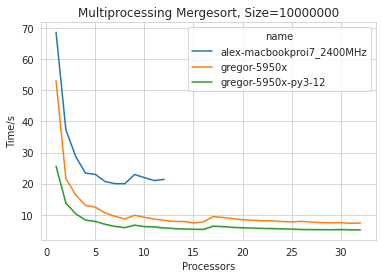

Empty DataFrame
Columns: [time, tag, name]
Index: []


IndexError: index 0 is out of bounds for axis 0 with size 0

In [41]:
size = 10000000
calculate_speedup(size)


In [13]:
def calculate_efficiency(size):
    tag = "multiprocessing_mergesort"
    data = []

    for file in files:
        try:
            _data = read_log(file, size=size)
            data = data + _data
        except:
            pass
    # print data
    print(data)

    df = pd.DataFrame(data = data, 
                      columns = ["processors", "time", "size", "name", "tag"])
    # df["speedup"] = df["time"].max()  / df["time"] 
    print(df["time"])

    plot_benchmark_by_size(df, size, tag, files)
    plt.show()

    # calculate average
    avg = pd.DataFrame()
    for name in files:
        _df = generate_average(df, tag="multiprocessing_mergesort", name=name, size=size)
        avg = pd.concat([avg, _df])
    # print(avg)

    # calculate speedup
    speedup = pd.DataFrame(avg)
    # speedup["p"] = speedup.index.get_level_values(0).astype(float)

    speedup_frames = []
    for name in files:
        # select all times with given user name
        df = speedup[speedup['name'] == name]
        time_for_one_processor = df.query('processors == 1').iat[0, 0]
        # calculate speedup by dividing time by time taken using one processor 
        df['speedup'] = df["time"].rdiv(time_for_one_processor)
        speedup_frames.append(df)

    result = pd.concat(speedup_frames)
    result['p'] = speedup.index.get_level_values(0).astype(float)
    result['efficiency'] = result['speedup'] / result['p']
    # print(result['efficiency'])

    plot_benchmark_by_size(result, size=size, tag=tag, files=files, x="processors", y="efficiency")
    plt.show()
    

LLL log/alex-10000000.log
LLL log/gregor-10000000.log
[[12, 21.369, 10000000, 'alex', 'multiprocessing_mergesort'], [11, 20.981, 10000000, 'alex', 'multiprocessing_mergesort'], [10, 21.921, 10000000, 'alex', 'multiprocessing_mergesort'], [9, 22.923, 10000000, 'alex', 'multiprocessing_mergesort'], [8, 19.963, 10000000, 'alex', 'multiprocessing_mergesort'], [7, 19.989, 10000000, 'alex', 'multiprocessing_mergesort'], [6, 20.665, 10000000, 'alex', 'multiprocessing_mergesort'], [5, 22.982, 10000000, 'alex', 'multiprocessing_mergesort'], [4, 23.366, 10000000, 'alex', 'multiprocessing_mergesort'], [3, 28.732, 10000000, 'alex', 'multiprocessing_mergesort'], [2, 37.347, 10000000, 'alex', 'multiprocessing_mergesort'], [1, 68.689, 10000000, 'alex', 'multiprocessing_mergesort'], [32, 7.318, 10000000, 'gregor', 'multiprocessing_mergesort'], [31, 7.232, 10000000, 'gregor', 'multiprocessing_mergesort'], [30, 7.411, 10000000, 'gregor', 'multiprocessing_mergesort'], [29, 7.414, 10000000, 'gregor', 'mul

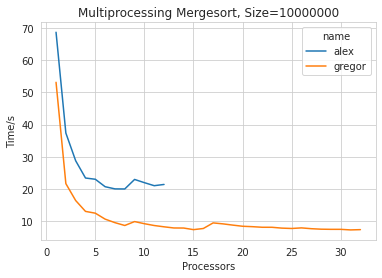

/tmp/ipykernel_208046/3729085768.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['speedup'] = df["time"].rdiv(time_for_one_processor)
/tmp/ipykernel_208046/3729085768.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['speedup'] = df["time"].rdiv(time_for_one_processor)


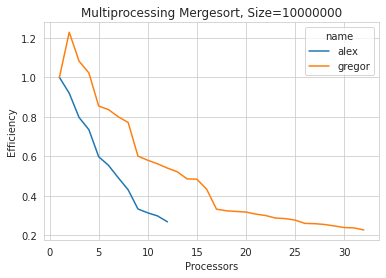

In [14]:
size = 10000000
calculate_efficiency(size)